In [1]:
import numpy as np
import pandas as pd
import scipy
import scipy.ndimage

from matplotlib import pyplot as plt

In [2]:
raw = pd.read_csv('../data/raw/f_7746236261c73c8a.csv', delimiter=';', decimal=',')

# Разделение набора данных на обучающую и тестовую выборки

Для обучения моделей будут использоваться данные первых 5 лет наблюдений (2010-2014). Наблюдения за последний год (2015) будут использованы для оценки точности прогнозирования. 

In [3]:
train = raw.iloc[:365 * 5 + 1] # 2012 - високосный год => в обучающую выборку попадает лишний день
test = raw.iloc[365 * 5 + 1:]

print('train:', len(train), '\ntest:', len(test))

train: 1826 
test: 365


# Предварительная обработка данных
## Энергопотребление 
числовой признак
* вычисляется среднее значение за сутки
* применяется стандартизация

In [4]:
e_labels = ['E' + str(i) for i in range(1, 25)]
e = train[e_labels]

e_avg = e.mean(axis=1)

Cтандартизация:

$ Z_i = \dfrac{X_i - \mu}{\sigma} $, 

где $\mu$ - среднее значение по выборке, $\sigma$ - стандартное отклонение

In [5]:
mean = e_avg.mean()
std = e_avg.std()

e_avg_std = (e_avg - mean) / std

e_params = [mean, std] # для дальнейшей сериализации 

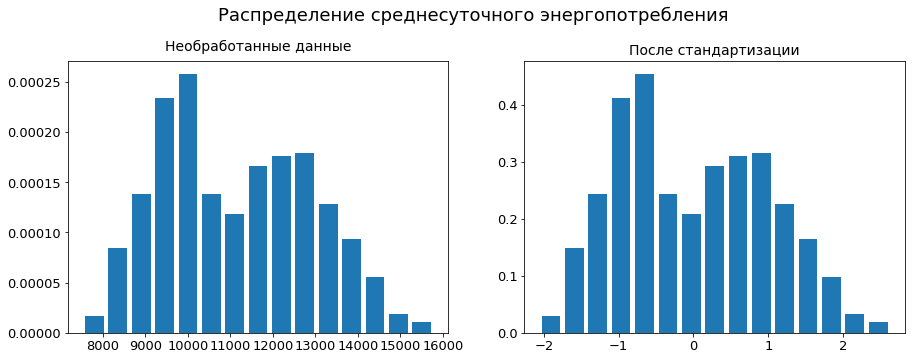

In [6]:
plt.rc('axes', titlesize=14)
plt.rc('xtick', labelsize=13)
plt.rc('ytick', labelsize=13)
plt.rc('figure', titlesize=18)

fig, axs = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Распределение среднесуточного энергопотребления', y=1.03)

axs[0].hist(e_avg, density=True, bins=15, rwidth=0.8)
axs[0].set_title('Необработанные данные', pad=10)

axs[1].hist(e_avg_std, density=True, bins=15, rwidth=0.8)
axs[1].set_title('После стандартизации')

plt.show()

## Температура
числовой признак
* вычисляется среднее значение за сутки
* применяется стандартизация 

In [7]:
t_labels = ['T' + str(i) for i in range(1, 25)]
t = train[t_labels]

t_avg = t.mean(axis=1)

In [8]:
t_avg_std = (t_avg - t_avg.mean()) / t_avg.std()

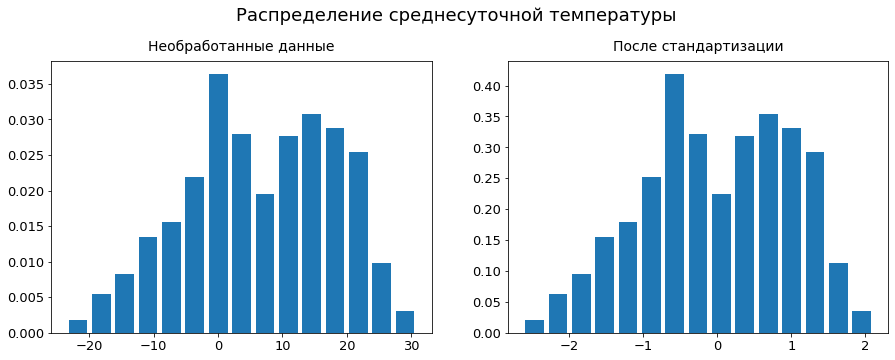

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Распределение среднесуточной температуры', y=1.03)

axs[0].hist(t_avg, density=True, bins=15, rwidth=0.8)
axs[0].set_title('Необработанные данные', pad=10)

axs[1].hist(t_avg_std, density=True, bins=15, rwidth=0.8)
axs[1].set_title('После стандартизации', pad=10)

plt.show()

## FT (?)
числовой признак
* применяется стандартизация

In [10]:
ft_labels = ['FT' + str(i) for i in range(4, 23, 6)]

ft = train[ft_labels]

In [11]:
ft_std = pd.DataFrame()

for label in ft_labels:
    ft_std[label] = (ft[label] - ft[label].mean()) / ft[label].std()

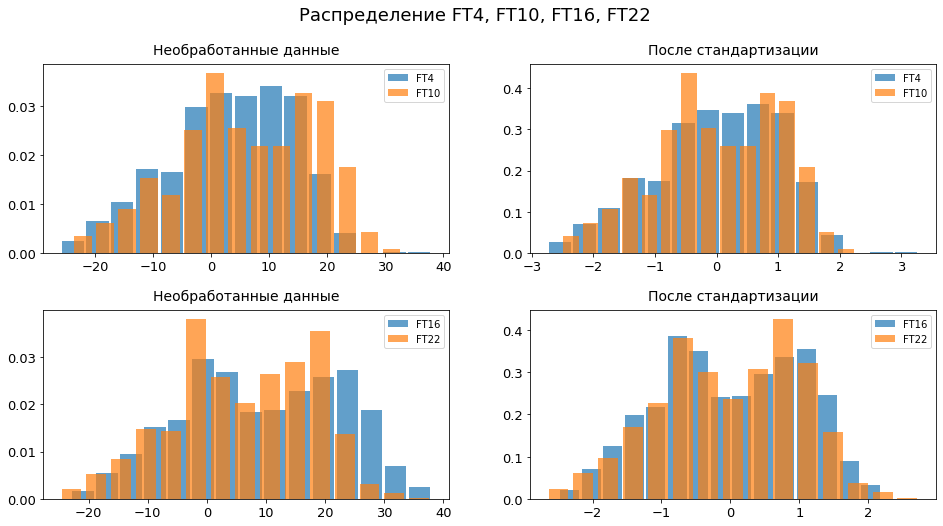

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(16,8))
fig.suptitle('Распределение FT4, FT10, FT16, FT22')
fig.subplots_adjust(hspace=0.3)

axs[0][0].hist(ft['FT4'], density=True, bins=15, rwidth=0.9, alpha=0.7, label='FT4')
axs[0][0].hist(ft['FT10'], density=True, bins=15, rwidth=0.8, alpha=0.7, label='FT10')
axs[1][0].hist(ft['FT16'], density=True, bins=15, rwidth=0.9, alpha=0.7, label='FT16')
axs[1][0].hist(ft['FT22'], density=True, bins=15, rwidth=0.8, alpha=0.7, label='FT22')
axs[0][0].legend()
axs[1][0].legend()
axs[0][0].set_title('Необработанные данные', pad=10)
axs[1][0].set_title('Необработанные данные', pad=10)

axs[0][1].hist(ft_std['FT4'], density=True, bins=15, rwidth=0.9, alpha=0.7, label='FT4')
axs[0][1].hist(ft_std['FT10'], density=True, bins=15, rwidth=0.8, alpha=0.7, label='FT10')
axs[1][1].hist(ft_std['FT16'], density=True, bins=15, rwidth=0.9, alpha=0.7, label='FT16')
axs[1][1].hist(ft_std['FT22'], density=True, bins=15, rwidth=0.8, alpha=0.7, label='FT22')
axs[0][1].legend()
axs[1][1].legend()
axs[0][1].set_title('После стандартизации', pad=10)
axs[1][1].set_title('После стандартизации', pad=10)


plt.show()

## День недели
категориальный признак
* применяется One-Hot кодирование

In [13]:
dow = pd.get_dummies(train['Day of week'])

dow.columns = ['DoW' + str(col) for col in dow.columns]

In [14]:
print('Необработанные данные: ', train['Day of week'], 
      'Закодированные данные: ', dow, 
      sep='\n\n')

Необработанные данные: 

0       5
1       6
2       7
3       1
4       2
       ..
1821    6
1822    7
1823    1
1824    2
1825    3
Name: Day of week, Length: 1826, dtype: int64

Закодированные данные: 

      DoW1  DoW2  DoW3  DoW4  DoW5  DoW6  DoW7
0        0     0     0     0     1     0     0
1        0     0     0     0     0     1     0
2        0     0     0     0     0     0     1
3        1     0     0     0     0     0     0
4        0     1     0     0     0     0     0
...    ...   ...   ...   ...   ...   ...   ...
1821     0     0     0     0     0     1     0
1822     0     0     0     0     0     0     1
1823     1     0     0     0     0     0     0
1824     0     1     0     0     0     0     0
1825     0     0     1     0     0     0     0

[1826 rows x 7 columns]


## Дата - месяц, день
категориальные признаки

Месяц кодируется аналогично дню недели, день кодируется порядковым номером.

In [15]:
parse_date = lambda x: [int(x['Date'][:x['Date'].find('.')]), 
                        int(x['Date'][x['Date'].find('.') + 1 : x['Date'].rfind('.')])]

day_month = train.apply(parse_date, axis=1, result_type='expand')

day = day_month[0]

month = pd.get_dummies(day_month[1])
month.columns = ['month' + str(col) for col in month.columns]

## Тип дня, время года
бинарные признаки


In [16]:
tod = train['Type of day'] - 1

In [17]:
wst = train['Winter-summer time'] - 1

# Объединение признаков

In [18]:
train_processed = pd.DataFrame()

train_processed['E'] = e_avg_std
train_processed['T'] = t_avg_std
train_processed['TOD'] = tod
train_processed['WST'] = wst
train_processed['day'] = day
train_processed = pd.concat([train_processed, dow, month, ft_std], axis=1)

print(train_processed)

             E         T  TOD  WST  day  DoW1  DoW2  DoW3  DoW4  DoW5  ...  \
0    -0.350721 -1.476255    1    0    1     0     0     0     0     1  ...   
1    -0.086256 -1.711234    1    0    2     0     0     0     0     0  ...   
2     0.157930 -2.115659    1    0    3     0     0     0     0     0  ...   
3     0.482281 -2.066057    1    0    4     1     0     0     0     0  ...   
4     0.438077 -1.621804    1    0    5     0     1     0     0     0  ...   
...        ...       ...  ...  ...  ...   ...   ...   ...   ...   ...  ...   
1821  1.260136 -1.316947    0    0   27     0     0     0     0     0  ...   
1822  1.221309 -1.462134    0    0   28     0     0     0     0     0  ...   
1823  1.754005 -1.817319    0    0   29     1     0     0     0     0  ...   
1824  1.726597 -1.925938    0    0   30     0     1     0     0     0  ...   
1825  1.293371 -1.638821    0    0   31     0     0     1     0     0  ...   

      month7  month8  month9  month10  month11  month12       F

# Сохранение данных

In [19]:
import pickle

with open('../data/var0.pkl', 'wb') as file:
    pickle.dump([train_processed, test, e_params], file)